# Working with the fruit fly body model

Welcome to the fruit fly body model tutorial! We'll start with some imports and interpreter configuration:

In [1]:
# Import standard library modules.
import os
import sys
from fnmatch import fnmatch
from pathlib import Path
from textwrap import wrap

# Tell Mujoco to use the "egl" renderer, which doesn't require a windowing system.
os.environ["MUJOCO_GL"] = "egl"

# Add the current directory to the module search path, so the interpreter can
# find the project library.
sys.path.append(".")

# Tell the interpreter to cache bytecode files in `_outbox/pycache/`.
sys.pycache_prefix = "_outbox/pycache/"

# Import third-party libraries.
import IPython.display
import matplotlib.pyplot as plt
import mujoco as mj
import numpy as np

# Import the project library.
import projectlib as pl

Next, let's download the body model directory, if we haven't already, and list the files within it:

In [2]:
pl.download_body_model_if_missing()

for _path in sorted(Path("_inbox/flybody").glob("**/*")):
    if _path.is_file():
        print(_path)

_inbox/flybody/abdomen_1_body.obj
_inbox/flybody/abdomen_1_lower.obj
_inbox/flybody/abdomen_2_body.obj
_inbox/flybody/abdomen_2_lower.obj
_inbox/flybody/abdomen_3_body.obj
_inbox/flybody/abdomen_3_lower.obj
_inbox/flybody/abdomen_4_body.obj
_inbox/flybody/abdomen_4_lower.obj
_inbox/flybody/abdomen_5_body.obj
_inbox/flybody/abdomen_5_lower.obj
_inbox/flybody/abdomen_6_body.obj
_inbox/flybody/abdomen_6_lower.obj
_inbox/flybody/abdomen_7_body.obj
_inbox/flybody/abdomen_7_lower.obj
_inbox/flybody/abdomen_8_body.obj
_inbox/flybody/antenna_left_black.obj
_inbox/flybody/antenna_left_body.obj
_inbox/flybody/antenna_right_black.obj
_inbox/flybody/antenna_right_body.obj
_inbox/flybody/blender_model/drosophila.blend
_inbox/flybody/coxa_T1_left_body.obj
_inbox/flybody/coxa_T1_right_body.obj
_inbox/flybody/coxa_T2_left_body.obj
_inbox/flybody/coxa_T2_right_body.obj
_inbox/flybody/coxa_T3_left_body.obj
_inbox/flybody/coxa_T3_right_body.obj
_inbox/flybody/femur_T1_left_body.obj
_inbox/flybody/femur_T

Here's an overview of what these files contain:

- `fruitfly.xml` is an [MJCF](https://mujoco.readthedocs.io/en/latest/modeling.html) specification of a [Mujoco](https://mujoco.readthedocs.io/en/stable/overview.html) model that contains the fruit fly as well as a few lights and cameras. (MJCF is Mujoco's XML model description format.) This file also specifies simulator settings, like the strength of gravity and the integration timestep, which we can override as needed.

- `floor.xml` is an MJCF file that [extends](https://mujoco.readthedocs.io/en/stable/XMLreference.html#include) `fruitfly.xml` by adding a well-polished checkered floor for the fly to stand and walk on.

- The `.obj` files describe body part meshes. They're referenced by `fruitfly.xml`, but we won't need to refer to them directly.

- `blender_model/drosophila.blend` is the [Blender](https://www.blender.org/) model that was used to generate `fruitfly.xml` and the mesh files.

Let's print the contents of `fruitfly.xml` to get a rough sense of what a Mujoco model consists of (skimming is highly encouraged):

In [3]:
print(Path("_inbox/flybody/fruitfly.xml").read_text())

<mujoco model="fruitfly">
  <compiler autolimits="true" angle="radian"/>

  <option timestep="0.0001" gravity="0 0 -981" density="0.00128" viscosity="0.000185" cone="elliptic" noslip_iterations="3"/>

  <size njmax="300" nconmax="100" nkey="1"/>

  <default>
    <mesh scale="0.1 0.1 0.1"/>
    <geom friction="0.5" solref="0.0002 1" solimp="0.95 0.99 0.01"/>
    <general ctrllimited="true"/>
    <default class="body">
      <joint limited="true" solreflimit="0.001 1" armature="1e-06"/>
      <geom type="mesh" contype="0" conaffinity="0" group="1" material="body" density="0.478"/>
      <site group="3" size="0.01"/>
      <default class="collision">
        <geom type="capsule" contype="1" conaffinity="1" condim="1" group="4" material="blue" density="0"/>
        <default class="adhesion-collision">
          <geom material="pink" friction="0.6" margin="0.0005" gap="0.0005"/>
          <site type="capsule"/>
        </default>
        <default class="collision-membrane">
          <geom 

At a high level, a Mujoco model is a tree of bodies, either connected in some way or moving freely with respect to one another, annotated with additional information about how the simulator should operate on them (*e.g.* the integration timestep size), how custom user code can operate on them (*e.g.*, sensors and actuators), and how they should be rendered (*e.g.*, textures).

MJCF is very thoroughly documented, especially relative to the Mujoco Python API as a whole, and you can learn a lot about Mujoco by reading the MJCF specification. However, working with XML trees directly (*e.g.* using the standard library's [XML module](https://docs.python.org/3/library/xml.etree.elementtree.html#module-xml.etree.ElementTree)) can be a bit verbose, so it can be helpful to convert an MJCF document into a [model specification object](https://mujoco.readthedocs.io/en/stable/programming/modeledit.html)—a mutable data structure whose components correspond directly to MJCF elements—before inspecting or editing it.

Let's use `floor.xml` to construct a model specification object and list the body, joint, sensor, and actuator specifications it contains:

In [4]:
def _print_model_spec_components() -> None:
    spec = mj.MjSpec.from_file("_inbox/flybody/floor.xml")  # type: ignore

    body_names = " ".join(b.name for b in spec.bodies)
    joint_names = " ".join(j.name for j in spec.joints)
    sensor_names = " ".join(s.name for s in spec.sensors)
    actuator_names = " ".join(a.name for a in spec.actuators)

    print(f"Bodies ({len(spec.bodies)}):")
    print("  " + "\n  ".join(wrap(body_names, width=120)))
    print(f"\nJoints ({len(spec.joints)}):")
    print("  " + "\n  ".join(wrap(joint_names, width=120)))
    print(f"\nSensors ({len(spec.sensors)}):")
    print("  " + "\n  ".join(wrap(sensor_names, width=120)))
    print(f"\nActuators ({len(spec.actuators)}):")
    print("  " + "\n  ".join(wrap(actuator_names, width=120)))

_print_model_spec_components()

Bodies (68):
  world thorax head wing_left wing_right abdomen haltere_left haltere_right coxa_T1_left coxa_T1_right coxa_T2_left
  coxa_T2_right coxa_T3_left coxa_T3_right rostrum antenna_left antenna_right haustellum labrum_left labrum_right
  abdomen_2 abdomen_3 abdomen_4 abdomen_5 abdomen_6 abdomen_7 femur_T1_left tibia_T1_left tarsus_T1_left tarsus2_T1_left
  tarsus3_T1_left tarsus4_T1_left claw_T1_left femur_T1_right tibia_T1_right tarsus_T1_right tarsus2_T1_right
  tarsus3_T1_right tarsus4_T1_right claw_T1_right femur_T2_left tibia_T2_left tarsus_T2_left tarsus2_T2_left
  tarsus3_T2_left tarsus4_T2_left claw_T2_left femur_T2_right tibia_T2_right tarsus_T2_right tarsus2_T2_right
  tarsus3_T2_right tarsus4_T2_right claw_T2_right femur_T3_left tibia_T3_left tarsus_T3_left tarsus2_T3_left
  tarsus3_T3_left tarsus4_T3_left claw_T3_left femur_T3_right tibia_T3_right tarsus_T3_right tarsus2_T3_right
  tarsus3_T3_right tarsus4_T3_right claw_T3_right

Joints (103):
  free head_abduct head

Now let's compile our model specification to create a model object, which represents our scene in a format that Mujoco can interface with efficiently, and run a simulation to see the fly shift from its initial pose to its resting pose:

In [5]:
def _render_resting_fly_video(output_path: str) -> None:
    spec = mj.MjSpec.from_file("_inbox/flybody/floor.xml")  # type: ignore
    model = spec.compile()

    sim_state = mj.MjData(model)  # type: ignore
    video_writer = pl.VideoWriter(output_path, duration=0.125, play_speed=0.025)
    render_fn = lambda: pl.render(model, sim_state, "track1", 480, 640)

    while video_writer.is_writing():
        mj.mj_step(model, sim_state)  # type: ignore
        video_writer.send(sim_state.time, render_fn)

_render_resting_fly_video("_outbox/vis-01.mp4")
IPython.display.Video("_outbox/vis-01.mp4", embed=True)

Generating frames... (125/125)
Encoding video...


`mj.mj_step` advances the simulation state one timestep, the duration of which is stored in `model.opt.timestep`.

## Taking measurements

A video can provide a holistic overview of what's happening in a simulation, but sometimes we want a bit more precision. Let's plot the left wing joint angles as a function of time over the first 250ms of the same simulation:

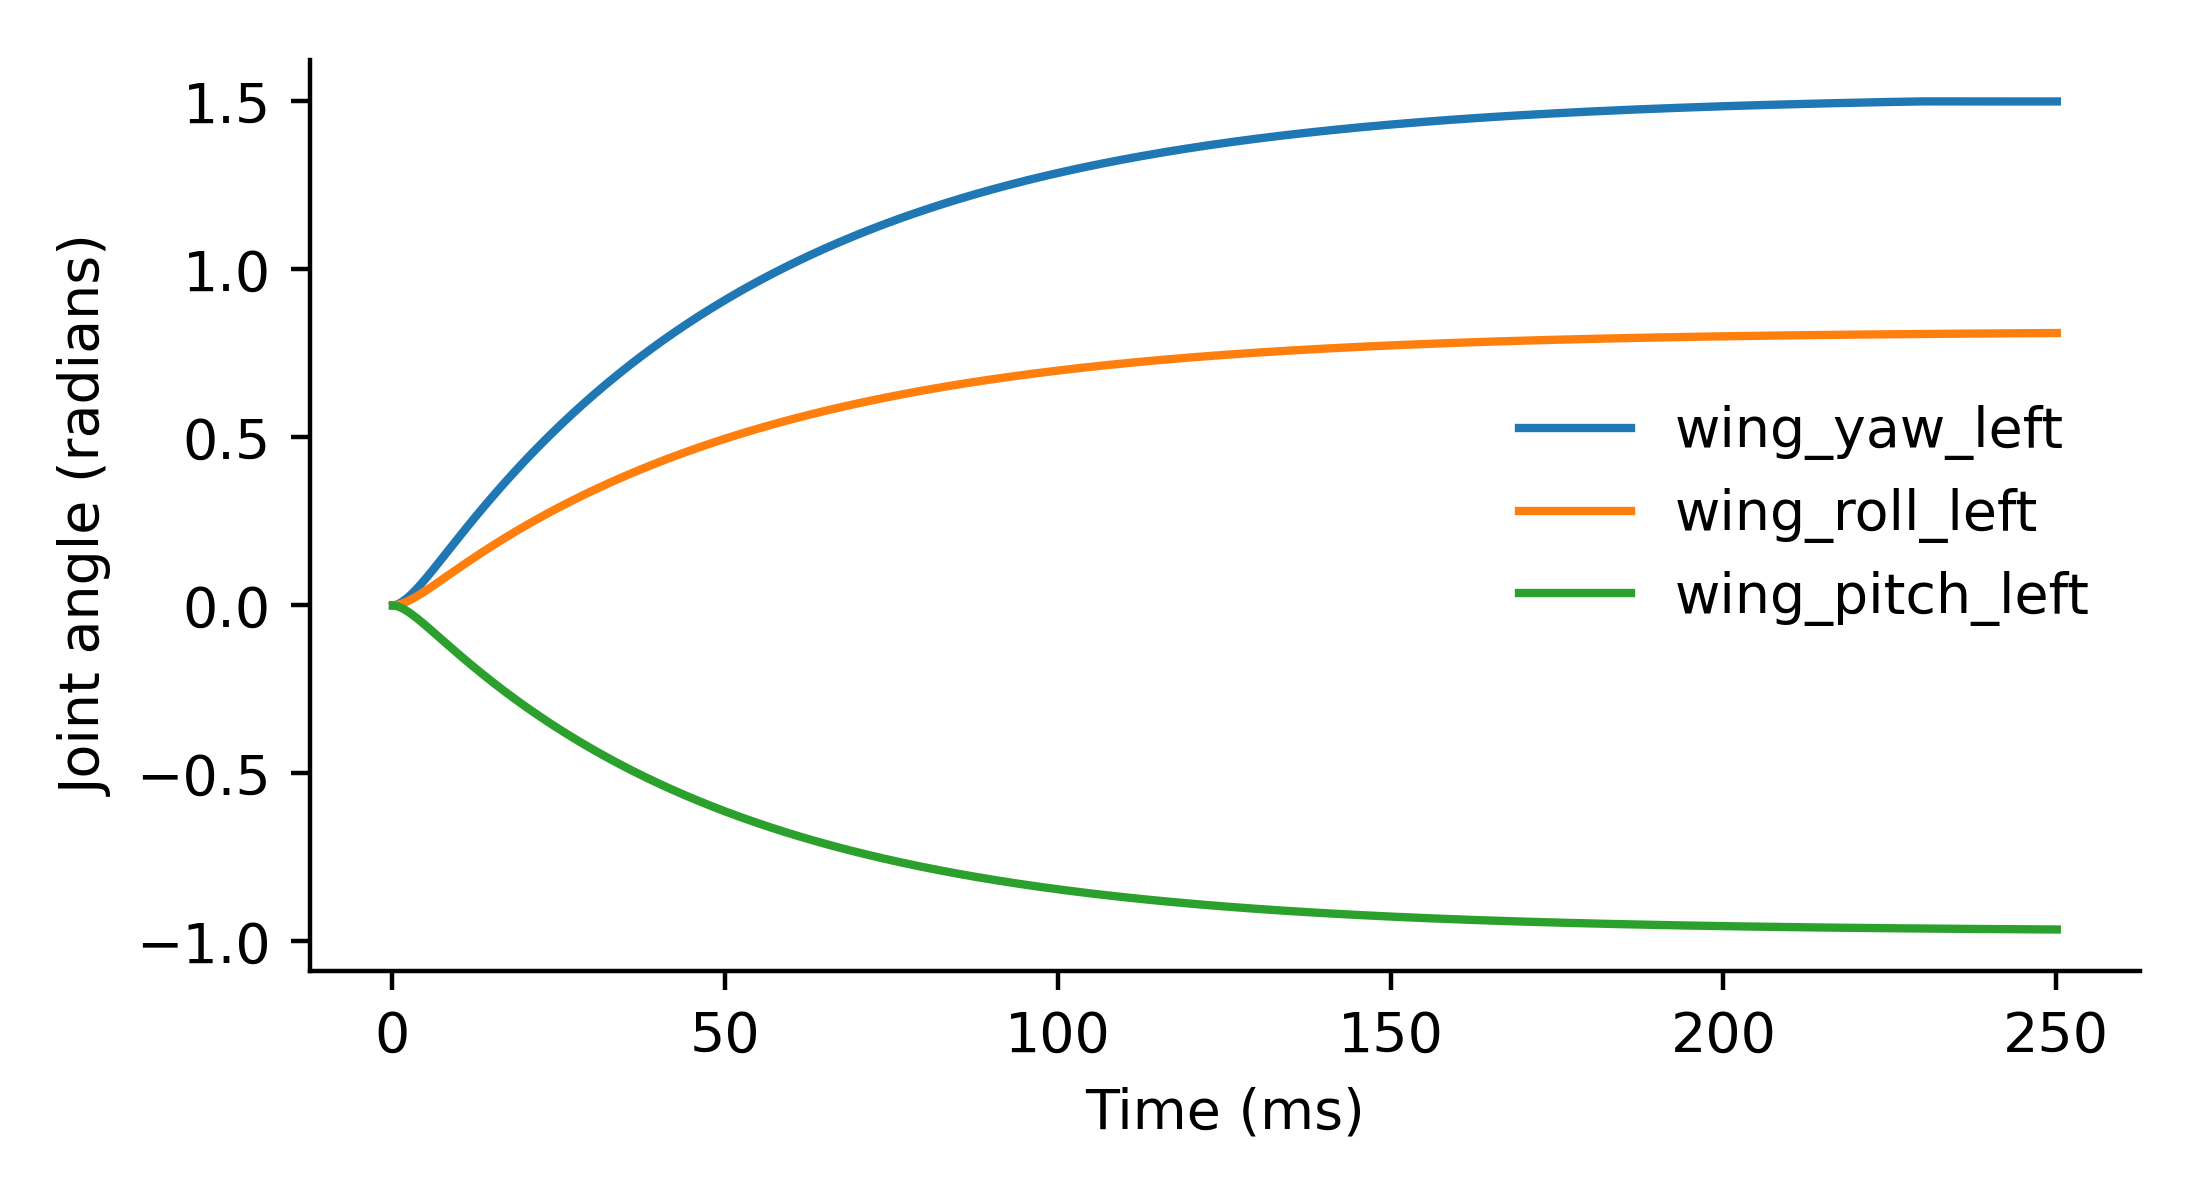

In [6]:
def _vis_left_wing_pose_trajectory(output_path: str) -> None:
    spec = mj.MjSpec.from_file("_inbox/flybody/floor.xml")  # type: ignore
    model = spec.compile()
    joint_names = [j.name for j in spec.joints if fnmatch(j.name, "wing_*_left")]

    sim_state = mj.MjData(model)  # type: ignore
    timestamps = list[float]()
    joint_angles = {name: list[float]() for name in joint_names}

    while sim_state.time < 0.25:
        mj.mj_step(model, sim_state)  # type: ignore
        timestamps.append(1000.0 * sim_state.time)
        for name in joint_names:
            joint_angles[name].append(sim_state.joint(name).qpos[0])

    plt.figure(figsize=(5.5, 3.0), dpi=400.0)
    plt.xlabel("Time (ms)")
    plt.ylabel("Joint angle (radians)")
    for name in joint_names:
        plt.plot(timestamps, joint_angles[name], label=name)
    plt.legend(frameon=False)
    plt.gca().spines[["top", "right"]].set_visible(False)
    plt.tight_layout()

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path)
    plt.close()

_vis_left_wing_pose_trajectory("_outbox/vis-02.png")
IPython.display.Image("_outbox/vis-02.png", width=640)

Mujoco uses `qpos` as a shorthand for "position in joint pose space" throughout its API. It also uses `qvel`, `xpos`, and `xvel` as shorthand for "velocity in joint pose space", "position in world Cartesian coordinates", and "velocity in world Cartesian coordinates", respectively.

Let's now rerun the simulation, plotting the location of the fly's center of mass. It turns out that we won't need to use a specification object for this next cell, so we can go straight from the MJCF file to the model by calling `mj.MjModel.from_xml_path`:

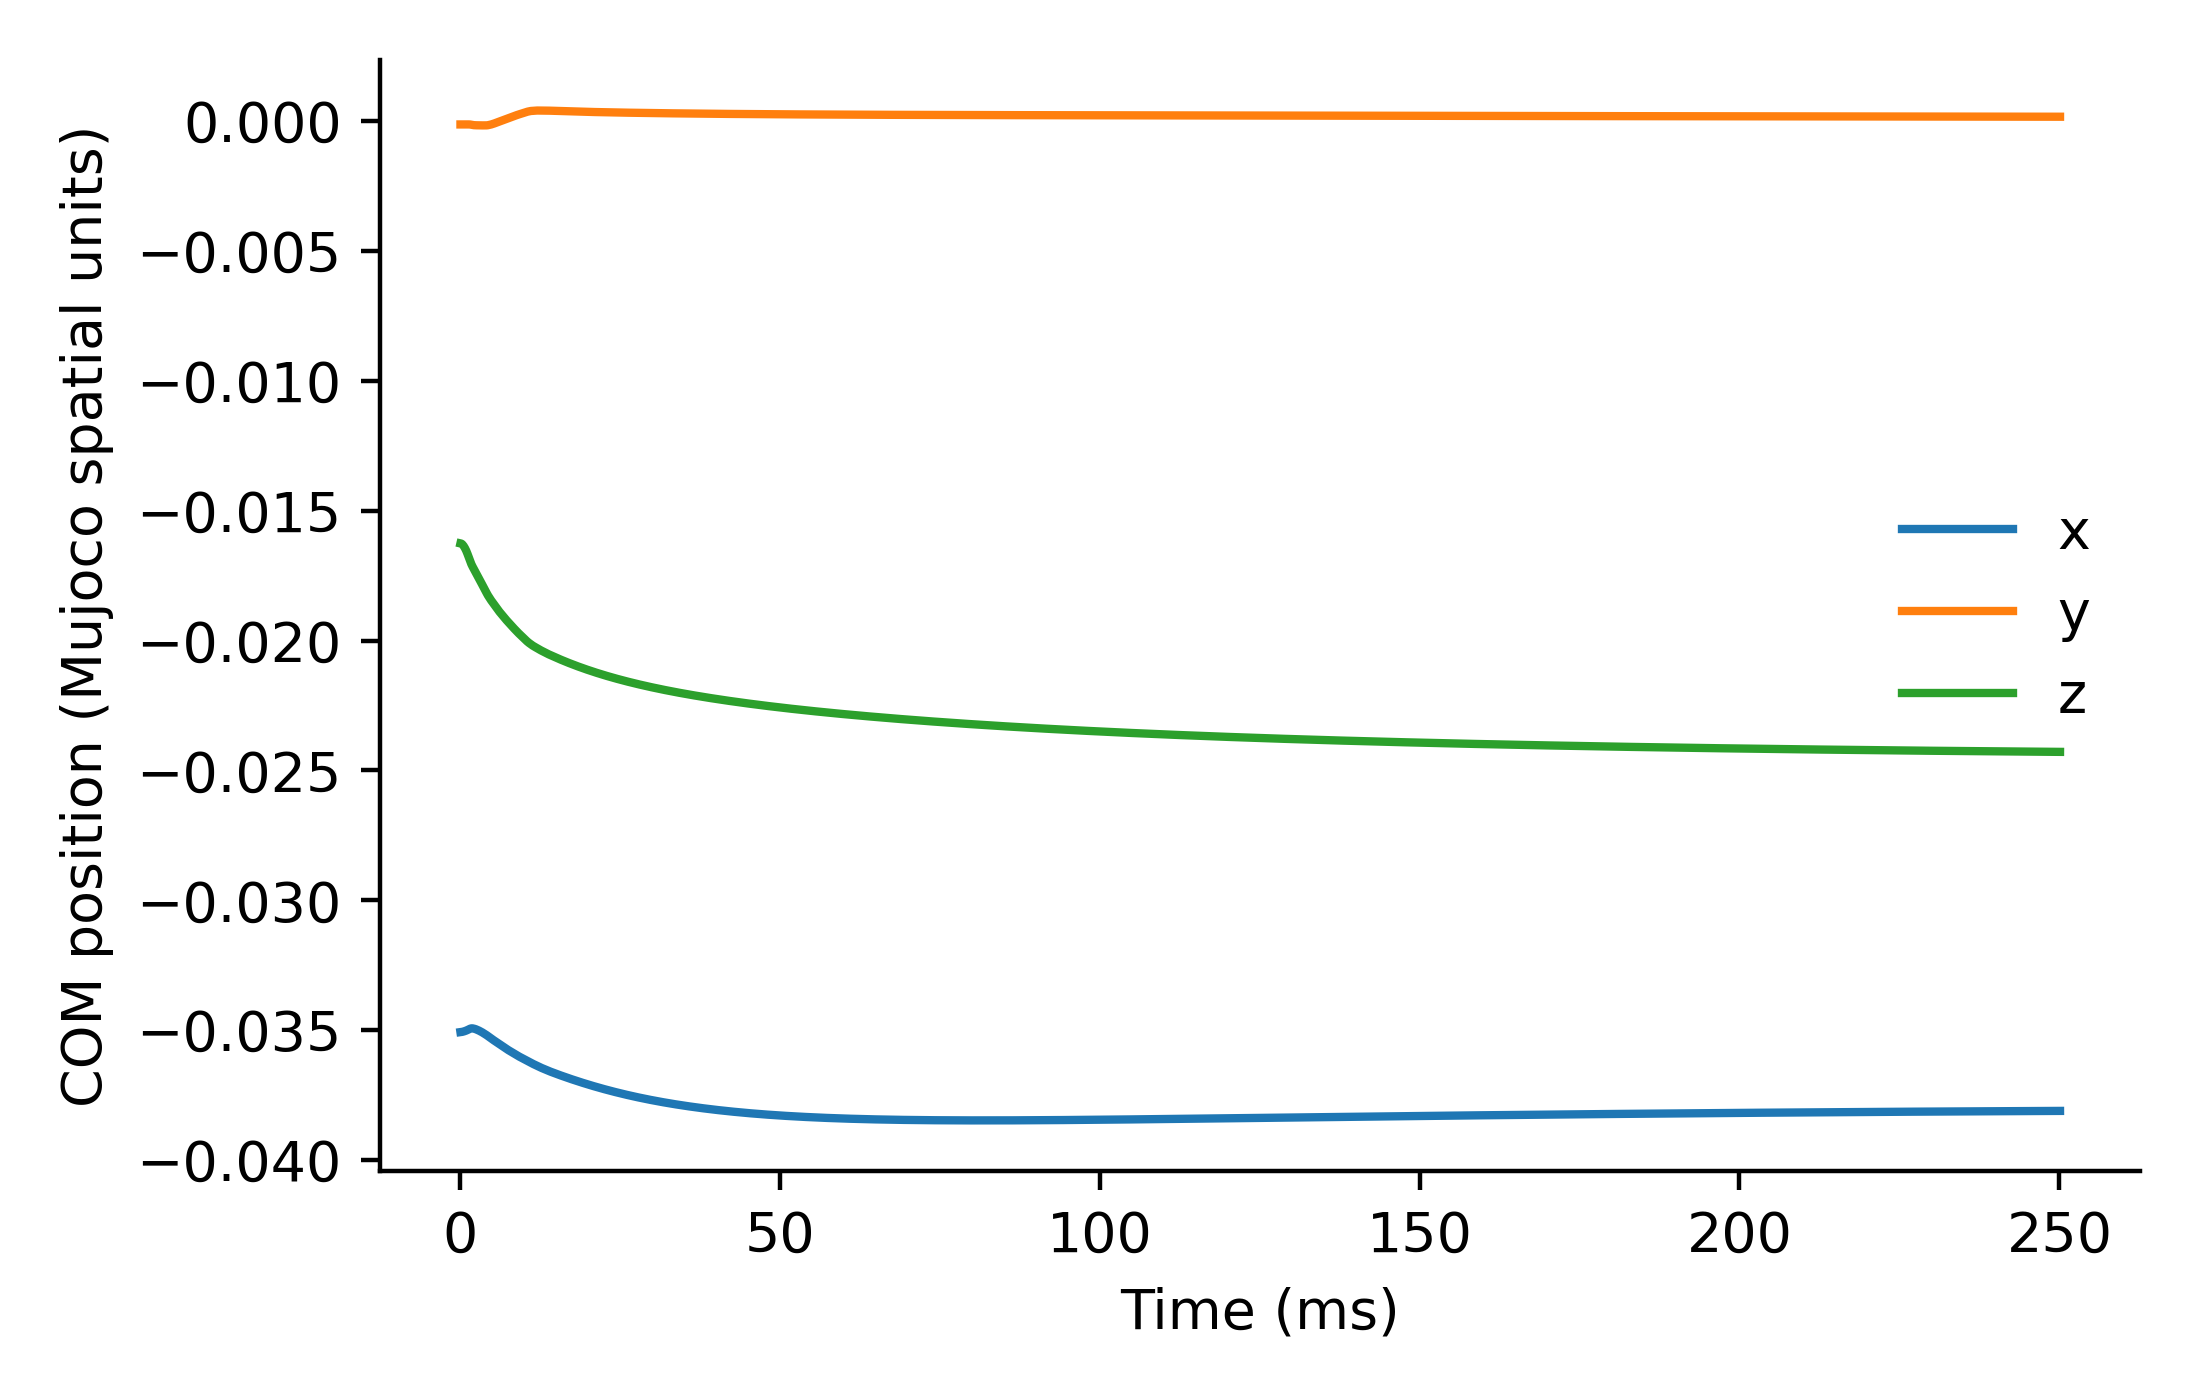

In [7]:
def _vis_com_trajectory(output_path: str) -> None:
    model = mj.MjModel.from_xml_path("_inbox/flybody/floor.xml")  # type: ignore
    sim_state = mj.MjData(model)  # type: ignore
    timestamps = list[float]()
    positions = {coord_name: list[float]() for coord_name in "xyz"}

    while sim_state.time < 0.25:
        mj.mj_step(model, sim_state)  # type: ignore
        timestamps.append(1000.0 * sim_state.time)
        com = sim_state.body("thorax").subtree_com
        positions["x"].append(com[0])
        positions["y"].append(com[1])
        positions["z"].append(com[2])

    plt.figure(figsize=(5.5, 3.5), dpi=400.0)
    plt.xlabel("Time (ms)")
    plt.ylabel("COM position (Mujoco spatial units)")
    for coord_name in "xyz":
        plt.plot(timestamps, positions[coord_name], label=coord_name)
    plt.legend(frameon=False)
    plt.gca().spines[["top", "right"]].set_visible(False)
    plt.tight_layout()
    
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path)
    plt.close()

_vis_com_trajectory("_outbox/vis-03.png")
IPython.display.Image("_outbox/vis-03.png", width=640)

And let's also plot the pressure measured by the fly's [tarsal](https://neuromechfly.org/_images/fly_anatomy.jpg) sensors at the very beginning of the simulation, as the fly settles onto the floor:

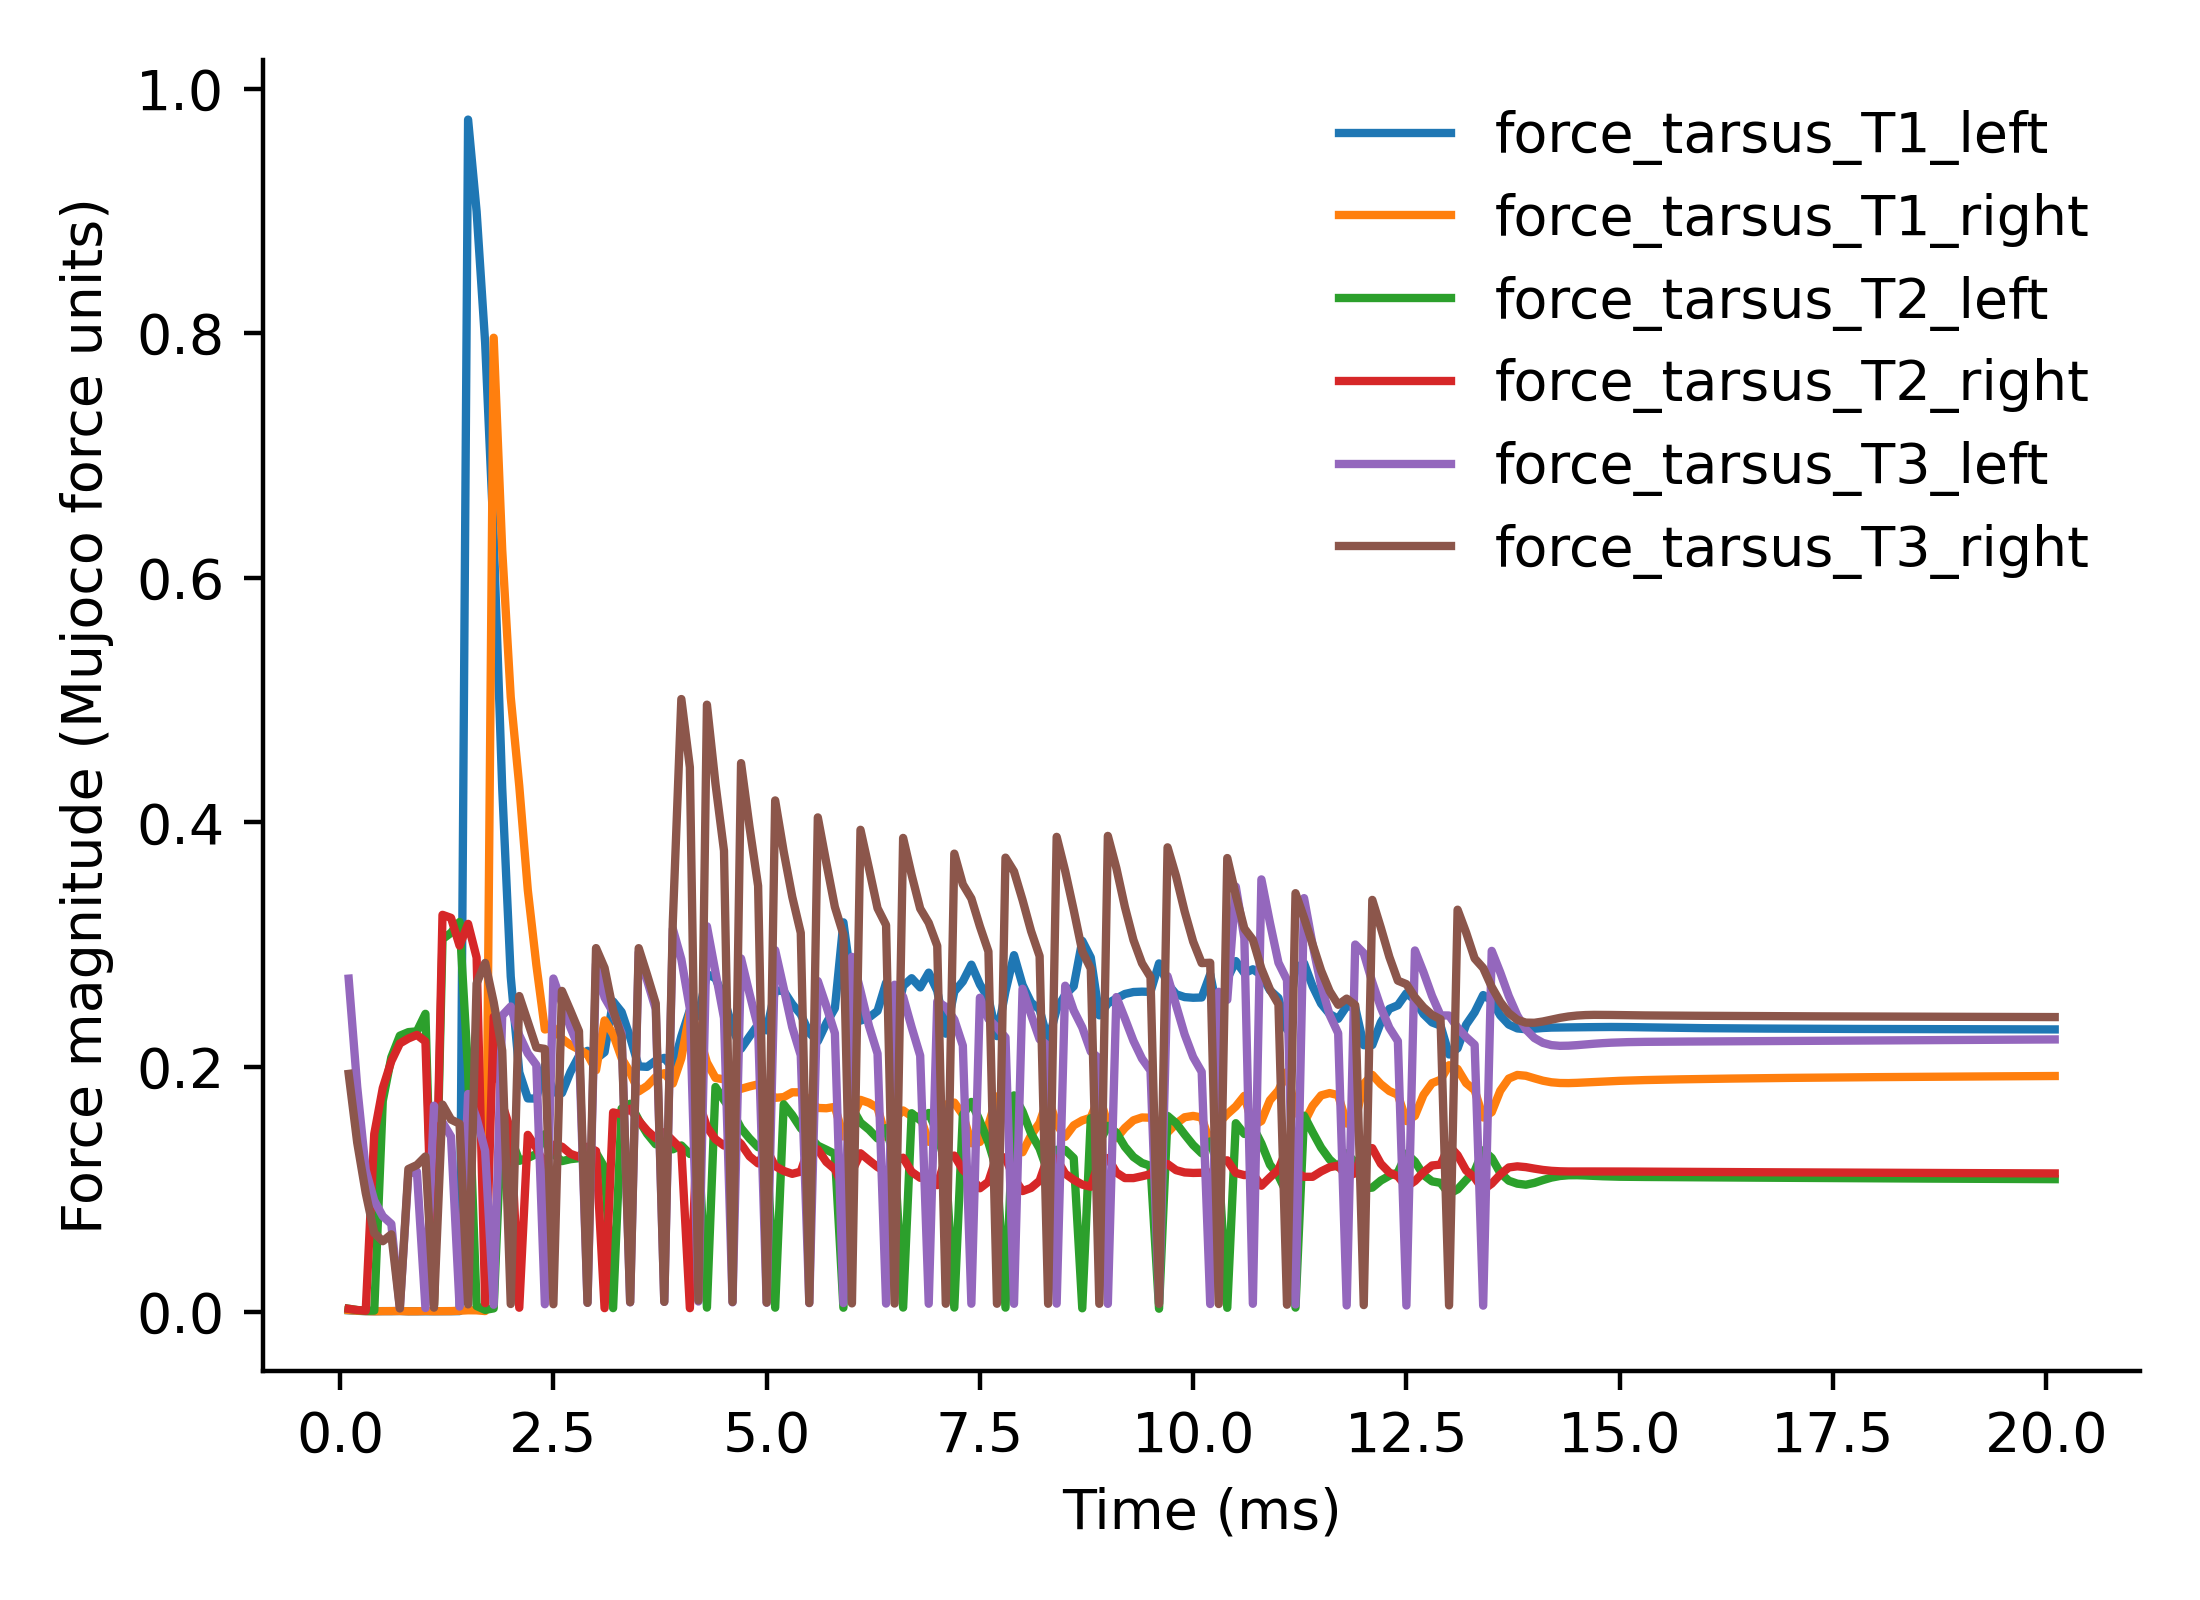

In [8]:
def _vis_force_measurements(output_path: str) -> None:
    spec = mj.MjSpec.from_file("_inbox/flybody/floor.xml")  # type: ignore
    model = spec.compile()
    force_sensor_code = mj.mjtSensor.mjSENS_FORCE  # type: ignore
    sensor_names = [s.name for s in spec.sensors if s.type == force_sensor_code]

    sim_state = mj.MjData(model)  # type: ignore
    timestamps = list[float]()
    force_measurements = {name: list[float]() for name in sensor_names}

    while sim_state.time < 0.02:
        mj.mj_step(model, sim_state)  # type: ignore
        timestamps.append(1000.0 * sim_state.time)
        for name in sensor_names:
            sensor = sim_state.sensor(name)
            measurement = float(np.linalg.norm(sensor.data))
            force_measurements[name].append(measurement)

    plt.figure(figsize=(5.5, 4.0), dpi=400.0)
    plt.xlabel("Time (ms)")
    plt.ylabel("Force magnitude (Mujoco force units)")
    for name in force_measurements:
        plt.plot(timestamps, force_measurements[name], label=name)
    plt.legend(frameon=False)
    plt.gca().spines[["top", "right"]].set_visible(False)
    plt.tight_layout()

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path)
    plt.close()

_vis_force_measurements("_outbox/vis-04.png")
IPython.display.Image("_outbox/vis-04.png", width=640)

## Stretching our limbs

Let's try sending control signals to a few of the fly's actuators:

In [9]:
def _vis_limb_actuation(output_path: str) -> None:
    model = mj.MjModel.from_xml_path("_inbox/flybody/floor.xml")  # type: ignore
    actuator_names = ["femur_T1_left", "tibia_T2_right", "tarsus_T3_left"]
    
    sim_state = mj.MjData(model)  # type: ignore
    video_writer = pl.VideoWriter(output_path, duration=0.20, play_speed=0.025)
    render_fn = lambda: pl.render(model, sim_state, "track1", 480, 640)

    while video_writer.is_writing():
        for i, actuator_name in enumerate(actuator_names):
            duration_active = video_writer.duration / (len(actuator_names) + 1)
            active_period_beg = i * duration_active
            active_period_end = (i + 1) * duration_active
            active = active_period_beg <= sim_state.time < active_period_end
            sim_state.actuator(actuator_name).ctrl[0] = 0.5 if active else 0.0
        mj.mj_step(model, sim_state)  # type: ignore
        video_writer.send(sim_state.time, render_fn)

_vis_limb_actuation("_outbox/vis-05.mp4")
IPython.display.Video("_outbox/vis-05.mp4", embed=True)

Generating frames... (200/200)
Encoding video...


An actuator will continue applying force until it receives a control signal of zero. However, joints can only move so far. Let's inspect the range of motion of each of the fly's leg joints:

In [10]:
def _print_motion_ranges() -> None:
    spec = mj.MjSpec.from_file("_inbox/flybody/fruitfly.xml")  # type: ignore
    leg_joints = [
        j for j in spec.joints
        if ("tarsus" in j.name or "tibia" in j.name or "femur" in j.name)
    ]

    for joint in leg_joints:
        print(f"`{joint.name}.qpos[0]` will always be in the range {joint.range}.")

_print_motion_ranges()

`femur_twist_T1_left.qpos[0]` will always be in the range [-1.  1.].
`femur_T1_left.qpos[0]` will always be in the range [-0.15  2.  ].
`tibia_T1_left.qpos[0]` will always be in the range [-1.35  1.3 ].
`tarsus_T1_left.qpos[0]` will always be in the range [-0.7  1.2].
`tarsus2_T1_left.qpos[0]` will always be in the range [-0.36  0.36].
`tarsus3_T1_left.qpos[0]` will always be in the range [-0.36  0.36].
`tarsus4_T1_left.qpos[0]` will always be in the range [-0.36  0.36].
`tarsus5_T1_left.qpos[0]` will always be in the range [-0.36  0.36].
`femur_twist_T1_right.qpos[0]` will always be in the range [-1.  1.].
`femur_T1_right.qpos[0]` will always be in the range [-0.15  2.  ].
`tibia_T1_right.qpos[0]` will always be in the range [-1.35  1.3 ].
`tarsus_T1_right.qpos[0]` will always be in the range [-0.7  1.2].
`tarsus2_T1_right.qpos[0]` will always be in the range [-0.36  0.36].
`tarsus3_T1_right.qpos[0]` will always be in the range [-0.36  0.36].
`tarsus4_T1_right.qpos[0]` will always be 

## Striking a pose

In [11]:
# TODO: Demonstrate inverse kinematics fitting

## Walking the walk

In [12]:
# TODO: Demonstrate using the walking controller

## Inclement weather

In [13]:
# TODO: Demonstrate using the walking controller in a situation it wasn't trained to handle (obstacles falling from the sky)

## Policy network electrophysiology

In [14]:
# TODO: Demonstrate measuring the control network's internal signals